# S-Wave Simulation

S-Wave or Secondary Wave or Shear Wave is the second seismic waves that arrived in the seismograph when earthquake happens. S-waves are transverse waves (direction of particle movement on S-wave is perpendicular to the direction of wave propagation). S-wave cannot traverse through liquids and gases. 

In [40]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

### Elastic Wave Equation
$$
\rho \frac{\partial^2 u_x}{\partial t^2} = \frac{\partial^2 \tau_{xy}}{\partial y} + S \\
\rho \frac{\partial^2 u_y}{\partial t^2} = \frac{\partial^2 \tau_{xy}}{\partial x} +S
$$

Where:
- $\rho$ is the density
- $\tau_{xy}$ is the shear stress
- $u_x, u_y$ is the horizontal and vertical displacements
- $S$ is the vertical force or source term (Ricker Wavelet)

In [41]:
# Simulation Area Parameter
NX, NY = 200, 200  #Grid size
XMIN, XMAX = 0.0, 2000.0  
YMIN, YMAX = 0.0, 2000.0  

# Animation Plot Parameter
PLOT_EVERY = 5  

In [42]:
# For Laplacian Approximation using FDM
DX = (XMAX - XMIN) / NX  # Spatial step (m)
DT = 0.001  # Time step (s)
NT = 1200  

#### Shear Modulus
Shear Modulus is used to measure how materials withstand deformation when a force is applied to the materials. The formula is
$$
\mu = \rho  v_s^2
$$

In [43]:
VS = np.ones((NX, NY)) * 1500.0  # shear wave velocity
RHO = np.ones((NX, NY)) * 2000.0  # Density
MU = RHO * VS**2  # Shear modulus 

# Two-layer model example:
# VS[NX//2:, :] = 2000.0  # Higher velocity layer
# RHO[NX//2:, :] = 2500.0  # Higher density layer
# MU = RHO * VS**2  # Recalculate shear modulus

In [44]:
ux = np.zeros((NX, NY))  # x-component of displacement
uy = np.zeros((NX, NY))  # y-component of displacement
ux_prev = np.zeros((NX, NY))  # Previous time step
uy_prev = np.zeros((NX, NY))  # Previous time step

tau_xy = np.zeros((NX, NY)) # shear stress

In [45]:
# Damping or Absorbing Boundary
ABL_WIDTH = 20 #grid point on simulation area's edge for absorbing
damping = np.ones((NX, NY)) 

# pressure on top and bottom get scaled down from 1.0 to 0.9
damping[:ABL_WIDTH, :] = np.linspace(0.9, 1.0, ABL_WIDTH)[:, np.newaxis]
damping[-ABL_WIDTH:, :] = np.linspace(1.0, 0.9, ABL_WIDTH)[:, np.newaxis]

# preserve the strongest damping when overlapping in left and right edge
damping[:, :ABL_WIDTH] = np.minimum(damping[:, :ABL_WIDTH], np.linspace(0.9, 1.0, ABL_WIDTH))
damping[:, -ABL_WIDTH:] = np.minimum(damping[:, -ABL_WIDTH:], np.linspace(1.0, 0.9, ABL_WIDTH))

### Ricker Wavelet
Ricker wavelet is the second derivative of a Gaussian function. It can mimic real seismic source, so we can conduct our numerical simulation based on it. The standard formula in the time domain is

$$
    A(t) = \left( 1-2\pi^2 f_0^2 t^2 \right) e^{- \pi^2 f_0^2 t^2}
$$
where
- $f_0$ is the peak frequency in Hertz

In [46]:
# Seismic source (Ricker wavelet at center)
def ricker_wavelet(t, f0=15.0):
    return (1.0 - 2.0*(np.pi*f0*t)**2) * np.exp(-(np.pi*f0*t)**2)

source_x, source_y = NX//4, NY//2  # Source position
source_times = np.arange(NT) * DT # Time values

# Pressure amplitude
# The peak will occur on t which is source_times-0.1 or in
# 0.1 seconds instead right at t=0, so that it is smoother
source_amp = ricker_wavelet(source_times - 0.1, f0=15.0) * 1e6  

#### Hooke Law 
Hooke Law is used for expressing the stress-strain relationship in the medium.
$$
\tau_{xy} = \mu \left( \frac{\partial u_y}{\partial x} + \frac{\partial u_x}{\partial y} \right)
$$

### Discretization
Now, based on Hooke's Law, we can compute the discretization of the partial derivatives using central differences FDM. 

$$
\frac{\partial u_x}{\partial y} \approx \frac{u_x^{i,j+1} - u_x^{i,j-1}}{2 \nabla y}
$$

Using leapfrog scheme, the time stepping is
$$
u_x^{t+1} = 2u_x^t - u_x^{t-1} + \frac{\Delta t^2}{\rho} \left( \frac{\tau_{xy}^{i,j+1} - \tau_{xy}^{i,j-1}}{2 \Delta y} + S \right)
$$


In [47]:
def update_wave(n):
    global ux, uy, ux_prev, uy_prev, tau_xy
    
    # Add source (vertical force)
    if n < len(source_amp):
        uy[source_x, source_y] += source_amp[n] * DT**2 / RHO[source_x, source_y]
    
    # Calculate spatial derivatives
    dux_dx = np.zeros_like(ux)
    dux_dy = np.zeros_like(ux)
    duy_dx = np.zeros_like(uy)
    duy_dy = np.zeros_like(uy)
    
    # Central differences for derivatives
    dux_dx[1:-1, 1:-1] = (ux[2:, 1:-1] - ux[:-2, 1:-1]) / (2*DX)
    dux_dy[1:-1, 1:-1] = (ux[1:-1, 2:] - ux[1:-1, :-2]) / (2*DX)
    duy_dx[1:-1, 1:-1] = (uy[2:, 1:-1] - uy[:-2, 1:-1]) / (2*DX)
    duy_dy[1:-1, 1:-1] = (uy[1:-1, 2:] - uy[1:-1, :-2]) / (2*DX)
    
    tau_xy_now = MU * (duy_dx + dux_dy)
    tau_xy[:, :] = tau_xy_now
    
    ux_new = np.zeros_like(ux)
    uy_new = np.zeros_like(uy)
    
    # x-component
    ux_new[1:-1, 1:-1] = (
        2*ux[1:-1, 1:-1] - ux_prev[1:-1, 1:-1] +
        (DT**2 / RHO[1:-1, 1:-1]) * (
            (tau_xy_now[1:-1, 2:] - tau_xy_now[1:-1, :-2]) / (2*DX)  # ∂τ_xy/∂y
        )
    )
    
    # y-component
    uy_new[1:-1, 1:-1] = (
        2*uy[1:-1, 1:-1] - uy_prev[1:-1, 1:-1] +
        (DT**2 / RHO[1:-1, 1:-1]) * (
            (tau_xy_now[2:, 1:-1] - tau_xy_now[:-2, 1:-1]) / (2*DX)  # ∂τ_xy/∂x
        )
    )
    
    ux_new *= damping
    uy_new *= damping
    
    ux_prev = ux.copy()
    uy_prev = uy.copy()
    ux = ux_new.copy()
    uy = uy_new.copy()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Horizontal displacement plot
img1 = ax1.imshow(ux.T, extent=[XMIN, XMAX, YMAX, YMIN], 
                 cmap='seismic', vmin=-1e-6, vmax=1e-6)
plt.colorbar(img1, ax=ax1, label='Horizontal Displacement (m)')
ax1.set_title("Horizontal Displacement (SV-Wave)")
ax1.set_xlabel("Distance (m)")
ax1.set_ylabel("Depth (m)")

# Vertical displacement plot
img2 = ax2.imshow(uy.T, extent=[XMIN, XMAX, YMAX, YMIN], 
                 cmap='seismic', vmin=-1e-6, vmax=1e-6)
plt.colorbar(img2, ax=ax2, label='Vertical Displacement (m)')
ax2.set_title("Vertical Displacement (SV-Wave)")
ax2.set_xlabel("Distance (m)")
ax2.set_ylabel("Depth (m)")

plt.show()

In [ ]:
def update(frame):
    """Update function for animation"""
    for _ in range(PLOT_EVERY):
        update_wave(frame * PLOT_EVERY + _)
    
    current_max = max(np.max(np.abs(ux)), np.max(np.abs(uy)))
    vlimit = current_max if current_max > 0 else 1e-6
    
    img1.set_array(ux.T)
    img1.set_clim(vmin=-vlimit, vmax=vlimit)
    
    img2.set_array(uy.T)
    img2.set_clim(vmin=-vlimit, vmax=vlimit)
    
    return [img1, img2]

In [ ]:
ani = FuncAnimation(fig, update, frames=NT//PLOT_EVERY, 
                   interval=50, blit=True)
plt.tight_layout()
plt.show()

In [ ]:
ffmpeg_writer = animation.FFMpegWriter(fps=20)
ani.save('test_s_wave1.mp4', writer=ffmpeg_writer)

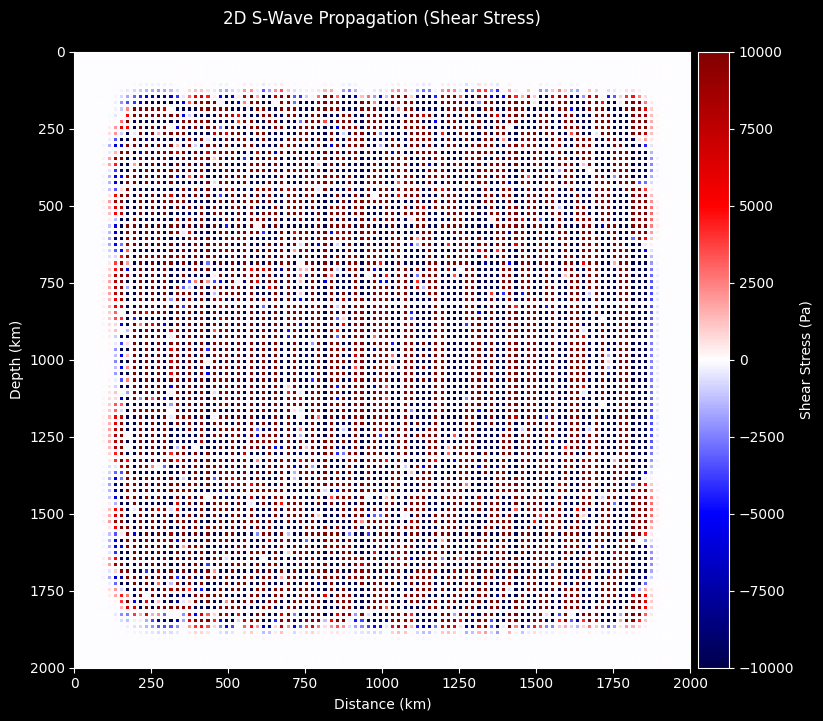

In [54]:
# plt.style.use('light_background')  # For better contrast
# fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
# extent = [XMIN/1000, XMAX/1000, YMAX/1000, YMIN/1000]  # km units

# # Improved Visualization Parameters
# img = ax.imshow(tau_xy.T, extent=extent,
#                cmap='seismic',
#                vmin=-1e5, vmax=1e5,
#                interpolation='bilinear',  # Smoother rendering
#                aspect='auto')

fig, ax = plt.subplots(figsize=(10, 8))
img = ax.imshow(tau_xy.T, extent=[XMIN, XMAX, YMAX, YMIN], 
                cmap='seismic', vmin=-1e4, vmax=1e4)

plt.colorbar(img, label='Shear Stress (Pa)', pad=0.01)
ax.set_title("2D S-Wave Propagation (Shear Stress)", pad=20)
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Depth (km)")
ax.grid(False)

from scipy.ndimage import gaussian_filter


def update_stress(frame):
    """Update function for animation"""
    for _ in range(PLOT_EVERY):
        update_wave(frame * PLOT_EVERY + _)
    tau_smoothed = gaussian_filter(tau_xy, sigma=1.0)
    img.set_array(tau_smoothed.T)
    img.set_clim(-np.max(np.abs(tau_smoothed)), np.max(np.abs(tau_smoothed)))  # Auto-scale
    return [img]

In [55]:
ani_stress = FuncAnimation(fig, update_stress, frames=NT//PLOT_EVERY, 
                   interval=50, blit=True)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [56]:
ffmpeg_writer = animation.FFMpegWriter(fps=20)
ani_stress.save('test_s_wave_stress_2.mp4', writer=ffmpeg_writer)

#### Seismic Moment
Seismic moment $M_0$ is used to measure the size of an earthquake. Seismic moment can be analogued as how big the snap or the earthquake was. The formula of seismic moment is as below.
$$
M_0 = \mu \overline{u} S
$$
where
- $\mu$ is the shear modulus,
- $\overline{u}$ is the mean (over the area of the fracture) of the amount of displacement caused by the earthquake,
- $S$ is the area of the fracture.

In [ ]:
# Rupture zone (ex: 10x10)
rupture_radius = 5
x_start, x_end = source_x - rupture_radius, source_x + rupture_radius
y_start, y_end = source_y - rupture_radius, source_y + rupture_radius

ux_rupture = ux[x_start:x_end, y_start:y_end] #x displacement in rupture zone
uy_rupture = uy[x_start:x_end, y_start:y_end] #y displacement in rupture zone
mu_rupture = MU[x_start:x_end, y_start:y_end] #mu in rupture zone

# total movement/displacement per point
u_magnitude = np.sqrt(ux_rupture**2 + uy_rupture**2)

# Average displacement (\overline{u})
u_avg = np.mean(u_magnitude)

# Average shear modulus (\mu)
mu_avg = np.mean(mu_rupture)

# Fracture area in m² (S)
# Each grid has physical size of DX, so the rupture area is a 10x10 square
# with the total area = (10 * DX) * (10 * DX) with 10 = 2 * rupture radius
S = ((2 * rupture_radius) * DX)**2  

M0 = mu_avg * u_avg * S
print(f"Seismic moment: {M0:.2e} Nm")

#### Moment Magnitude and Energy Released
The moment magnitude $M_w$ is a measure of energy released by an earthquake. In other words, it is a measurement scale of the power of the earthquake. The moment magnitude is the new standard taht works for all earthquake. The old standard is the Richter scale where it is babsed on ground motion measured by seismograph. The formula of $M_w$ is 
$$
M_w = \frac{2}{3} \log{M_0} - 10.7 
$$
where $M_0$ is the seismic moment in dyne.cm.

The approximation of the energy released can be calculated using the moment magnitude. The formula is as below.
$$
\log{E} \approx 5.24 + 1.44 M_w
$$
where $M_w$ is the moment magnitude. $M_w$ is dimensionless.

In [ ]:
# convert M0 to dyne.cm
M0_dynecm = M0 * 10000000 

# moment magnitude
Mw = (2/3) * math.log(M0_dynecm) - 10.7
print(f"Moment magnitude scale: {Mw}")

# energy released
E = 10**(5.24 + (1.44 * Mw))
print(f"Energy released: {E:.2e} J")